# Evaluating the Solution Algorithms

## Generating more test data

Eventually I found my way to [Peter Norvig's Sudoku Solver](https://norvig.com/sudoku.html). Yes [that Peter Norvig](http://aima.cs.berkeley.edu/). He has a lot more test puzzles that I've added here. His code is clear, elegant, and blistering fast. But then he's the [Director of Research at Google](https://norvig.com/) so I'm trying not to feel bad. :-)


In [1]:
import copy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 3)

In [2]:
import sys
sys.path.insert(-1, '..')

import puzzle.tester as tester
import puzzle.sudoku as su
from puzzle.jupyter_helpers import *
display(HTML(SUDOKU_CSS))

In [3]:
pt = tester.PuzzleTester(puzzle_class=su.SudokuPuzzle)
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard']  # ['Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]
pt.add_test_cases(test_cases)

8

In [4]:
for method in su.SOLVERS:
    solver = su.SudokuSolver(method=method)
    pt.run_tests(solver, label=method, callback=update_progress)

In [5]:
def show_results(pt, axis=None):
    df = pd.DataFrame(pt.get_test_results())
    all_methods = list(pt.get_solver_labels())
    style1 = df.style.highlight_null().highlight_max(axis=axis, color='orange', subset=all_methods).highlight_min(axis=axis, color='green', subset=all_methods).format({m: '{:.3f}' for m in all_methods})
    return style1

show_results(pt)

,label,level,starting_clues,backtracking,constraintpropogation,deductive,sat
0,SMH 1,Kids,31,0.020,0.002,0.004,0.027
1,SMH 2,Easy,24,0.197,0.004,0.006,0.026
2,KTH 1,Easy,30,0.013,0.002,0.003,0.025
3,Rico Alan Heart,Easy,22,0.089,0.036,0.025,0.019
4,SMH 3,Moderate,26,0.087,0.024,0.034,0.023
5,SMH 4,Hard,22,1.442,0.037,0.037,0.020
6,SMH 5,Hard,25,0.593,0.030,0.027,0.021
7,Greg [2017],Hard,21,0.619,0.057,0.052,0.026


If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).

In [6]:
import os.path
import datetime

TEST_RESULTS = "../data/sudoku_test_results.pkl"
NUM_SAMPLES = 5

pt = tester.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_test_cases([x for x in su.SAMPLE_PUZZLES])
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/hardest.txt", level="Hard"))
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/top95.txt", level="Diabolical"))
print(f"Using {pt.num_test_cases()} test cases")

if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
    print(f"Read previous test results from {TEST_RESULTS} from {datetime.datetime.fromtimestamp(os.path.getmtime(TEST_RESULTS))}")
    pt.set_test_results(df.to_dict('list'))

else:
    print(f"Generating {TEST_RESULTS} at {datetime.datetime.now()}...")
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)
    print(f"Saved {TEST_RESULTS} at {datetime.datetime.now()}")


Using 125 test cases
Read previous test results from ../data/sudoku_test_results.pkl from 2020-09-11 18:25:10.473189


## Results summary

In [7]:
df.describe()

,starting_clues,backtracking,constraintpropogation,deductive,sat
count,122.000,122.000,122.000,122.000,122.000
mean,21.189,46.760,0.564,0.254,0.021
std,3.402,159.589,1.713,0.761,0.003
min,17.000,0.006,0.001,0.001,0.018
25%,17.000,0.308,0.017,0.020,0.019
50%,22.000,2.086,0.058,0.045,0.020
75%,23.000,11.893,0.190,0.121,0.023
max,31.000,1173.908,12.076,5.219,0.043


Some quick observatiobs:

* Backtracking alone is appalling. Look it:
 * 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
 * Mean time is terrible for backtracking alone (~46 seconds).
 * Standard deviation is wide, because the performance is so variable
* The SAT solver is pretty fast, and its performance is also a lot more consistent. That kind of makes sense now because the number of boolean propositions that have to be satisfied for any given puzzle doesn't actually change that much.
* Constraint Propogation is the overall best performer from my own code, but it seems to pay to try and deduce a few cells first. This makes sense as well, because each cell that can be definitively solved can cut the search space significantly.

You can see the variability between the methods better with the following plot.

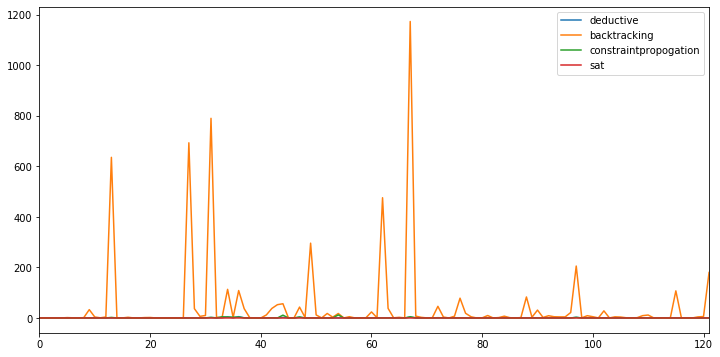

In [8]:
all_methods = list(pt.get_solver_labels())
ax = df[all_methods].plot()
#ax.set_facecolor("#161716")

The scale of backtracking obscures the differences between the other methods. 

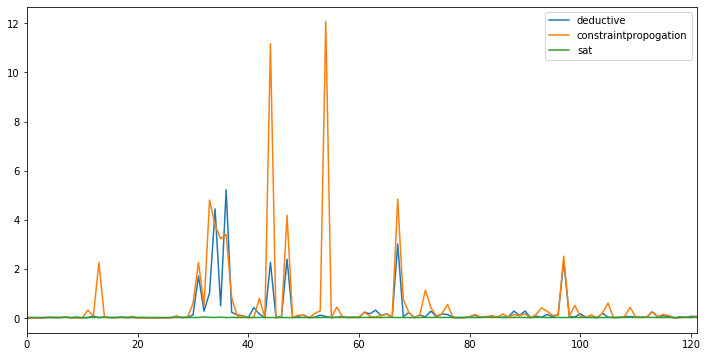

In [9]:
all_methods.remove('backtracking')
axs = df[all_methods].plot()

So this just seems to fit the same pattern, but because constraint propogation dramatically cuts the search space, the performance is generally faster. Those "spikes" are where a particular guess turns out to be *really bad* and there is a lot of backtracking to do.

You can also see the effect of the deductive solver. By solving a few cells straight away we cut the search space -- but there's still the occassional "bad guess" that triggers some backtracking.

A better visualisation tool for this kind of data might be a [boxplot](http://vita.had.co.nz/papers/boxplots.pdf).

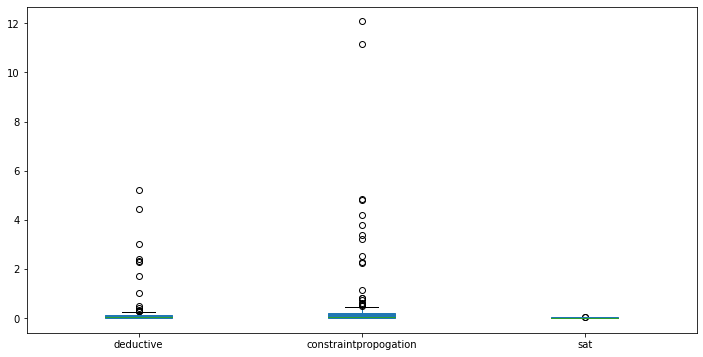

In [11]:
ax = df[all_methods].plot(kind='box', patch_artist=True)

Actually, the boxplot is a terrible choice because the scale of times for constraint propogation flattens the sat boxplot to a very thin pancake.

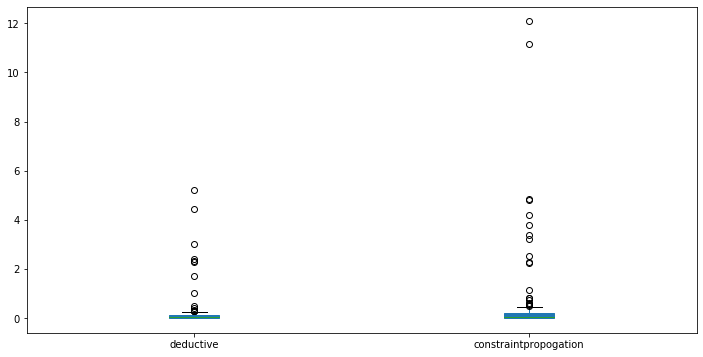

In [12]:
ax = df[['deductive', 'constraintpropogation']].plot(kind='box', patch_artist=True)

Above chart shows how the performace of the SAT solver is consistently fast. I admit I don't fully understand the code, since I'm relying on [pycosat](https://pypi.org/project/pycosat/) for the SAT part, and cribbing [implementation details](https://github.com/ContinuumIO/pycosat/blob/master/examples/sudoku.py) from [Ilan Schnell](http://ilan.schnell-web.net/prog/sudoku/) for generating the clauses. The conversion of a puzzle to a set of boolean clauses I eventually understood -- but the actual SAT solution algorithm is confusing me still.

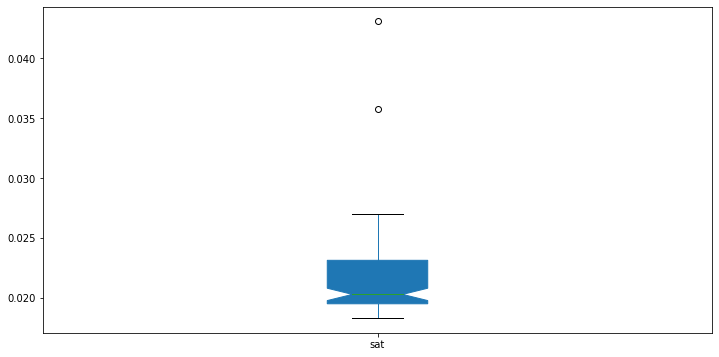

In [43]:
axs = df['sat'].plot(kind="box", notch=True, patch_artist=True)

So there is *some* variability in performance, just not a lot. Should also mention that `pycosat` is a wrapper around a C library called PicoSAT, which would be one reason why it's so much faster (that, and about 20 years of academic research on SAT solvers)!